In [ ]:
#@test {"skip": true}
!pip install numpy==1.25.2 scipy tensorflow==2.14.1 tensorflow_federated==0.84.0

In [ ]:
import collections

import numpy as np
import tensorflow as tf
import tensorflow_federated as tff

ERROR:jax._src.xla_bridge:Jax plugin configuration error: Plugin module %s could not be loaded
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/xla_bridge.py", line 428, in discover_pjrt_plugins
    plugin_module = importlib.import_module(plugin_module_name)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/importlib/__init__.py", line 126, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<frozen importlib._bootstrap>", line 1204, in _gcd_import
  File "<frozen importlib._bootstrap>", line 1176, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1147, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 690, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 940, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_r

In [ ]:
import pickle
from sklearn.model_selection import train_test_split

# Load MNIST
(x_train_full, y_train_full), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_full = np.concatenate([x_train_full, x_test])
y_full = np.concatenate([y_train_full, y_test])

# Normalize
x_full = x_full.astype('float32') / 255.0
x_full = x_full.reshape((-1, 28, 28, 1))

# Split into train/test (e.g., 80/20)
x_train, x_test, y_train, y_test = train_test_split(x_full, y_full, test_size=0.2, random_state=42)

# Save to disk
with open("train_data.pkl", "wb") as f:
    pickle.dump((x_train, y_train), f)

with open("test_data.pkl", "wb") as f:
    pickle.dump((x_test, y_test), f)


11490434/11490434 [==============================] - 0s 0us/step


**Segregate by class**

In [ ]:
def get_data_for_digits(source, digits):
  samples = [
      i for digit in digits for i, d in enumerate(source[1]) if d == digit
  ]
  output_sequence = []

  for i in range(0, len(samples), BATCH_SIZE):
    batch_samples = samples[i:i + BATCH_SIZE]
    output_sequence.append({
        'x':
            np.array([tf.expand_dims(source[0][i] / 255.0, -1) for i in batch_samples],
                     dtype=np.float32),
        'y':
            np.array([source[1][i] for i in batch_samples], dtype=np.int32)
    })
  return output_sequence

**Aggregation-free (non-iid)**

In [ ]:
import numpy as np
import tensorflow as tf

BATCH_SIZE = 100

def dirichlet_partitioning(y, num_clients, alpha):
    """
    Splits the dataset among `num_clients` using Dirichlet distribution with concentration `alpha`.

    Args:
        y: Labels array.
        num_clients: Number of clients.
        alpha: Dirichlet concentration parameter (lower = more non-IID).

    Returns:
        List of index lists per client.
    """
    num_classes = len(np.unique(y))
    indices_per_class = {i: np.where(y == i)[0] for i in range(num_classes)}

    client_indices = [[] for _ in range(num_clients)]

    for c in range(num_classes):
        class_indices = indices_per_class[c]
        np.random.shuffle(class_indices)

        proportions = np.random.dirichlet(alpha * np.ones(num_clients))
        proportions = (np.cumsum(proportions) * len(class_indices)).astype(int)[:-1]
        split_indices = np.split(class_indices, proportions)

        for i, idx in enumerate(split_indices):
            client_indices[i].extend(idx.tolist())

    return client_indices

def get_dirichlet(source, alpha, num_clients):
    """
    Create federated data batches for each client using Dirichlet-distributed sampling.

    Args:
        source: Tuple of (x_data, y_data).
        alpha: Dirichlet concentration parameter.
        num_clients: Number of clients.

    Returns:
        List of client datasets. Each dataset is a list of batches (dicts with 'x' and 'y').
    """
    output_sequence = []
    clients_data = []
    client_indices = dirichlet_partitioning(source[1], num_clients, alpha)

    for client_id in range(num_clients):
        indices = client_indices[client_id]
        np.random.shuffle(indices)

        # Create batches
        for i in range(0, len(indices), BATCH_SIZE):
            batch_indices = indices[i:i + BATCH_SIZE]

            #  CORRECT SHAPE: [28, 28, 1]
            batch_x = np.array(
                [np.reshape(source[0][j] / 255.0, (28, 28, 1)) for j in batch_indices],
                dtype=np.float32
            )
            batch_y = np.array([source[1][j] for j in batch_indices], dtype=np.int32)

            output_sequence.append({'x': batch_x, 'y': batch_y})

        clients_data.append(output_sequence)
        output_sequence = []  # Clear for next client

    return clients_data


In [ ]:
mnist_train, mnist_test = tf.keras.datasets.mnist.load_data()

federated_test_data=[get_data_for_digits(mnist_test, [d]) for d in range(10)]

**IID distribution (FEDTSA)**

In [ ]:
import numpy as np
import tensorflow as tf

def fedtsa_distribution(data, num_clients, num_classes):
    """
    Distributes data IID across clients in FedTSA-compliant format.

    Args:
        data: Tuple (x_train, y_train), e.g. from tf.keras.datasets.mnist.load_data()
        num_clients: Number of clients to split the data among.
        num_classes: Number of classes in the dataset (e.g., 10 for MNIST)

    Returns:
        List of client datasets, each as a list of dict batches {'x': ..., 'y': ...}
    """
    batch_size = 32  # Must match input_spec in TFF model

    x_train, y_train = data

    #  Ensure shape is (N, 28, 28, 1)
    x_train = x_train.astype(np.float32) / 255.0
    x_train = np.reshape(x_train, (-1, 28, 28, 1))
    y_train = y_train.astype(np.int32)

    indices = np.arange(len(x_train))
    np.random.shuffle(indices)
    client_indices = np.array_split(indices, num_clients)

    federated_train_data = []

    for idxs in client_indices:
        x_client = x_train[idxs]
        y_client = y_train[idxs]

        # Shuffle client data
        perm = np.random.permutation(len(x_client))
        x_client = x_client[perm]
        y_client = y_client[perm]

        # Batch client data
        batches = []
        for i in range(0, len(x_client), batch_size):
            batch_x = x_client[i:i + batch_size]
            batch_y = y_client[i:i + batch_size]
            batches.append({'x': batch_x, 'y': batch_y})

        federated_train_data.append(batches)

    return federated_train_data





**IID Distribution (Energy aware)**

In [ ]:
import numpy as np
import tensorflow as tf
from collections import defaultdict
import random

def energy_aware(x, y, num_clients=5, ncc=3, batch_size=32, max_batches=100):
    def assign_classes_to_devices(C, N, K):
        if C > N * K:
            raise ValueError("Not enough capacity to assign all classes.")
        device_classes = defaultdict(set)
        class_to_devices = defaultdict(set)
        for class_id in range(C):
            available_devices = [d for d in range(N) if len(device_classes[d]) < K]
            if not available_devices:
                raise ValueError(f"No available devices to assign class {class_id}")
            chosen_device = random.choice(available_devices)
            device_classes[chosen_device].add(class_id)
            class_to_devices[class_id].add(chosen_device)
        for device_id in range(N):
            while len(device_classes[device_id]) < K:
                possible_classes = [c for c in range(C) if c not in device_classes[device_id]]
                if not possible_classes:
                    break
                chosen_class = random.choice(possible_classes)
                device_classes[device_id].add(chosen_class)
                class_to_devices[chosen_class].add(device_id)
        device_classes = {k: sorted(list(v)) for k, v in device_classes.items()}
        class_to_devices = {k: sorted(list(v)) for k, v in class_to_devices.items()}
        return device_classes, class_to_devices

    num_classes = len(np.unique(y))
    assigned_classes, class_to_clients = assign_classes_to_devices(num_classes, num_clients, ncc)
    client_data_indices = {i: [] for i in range(num_clients)}

    for cls, clients in class_to_clients.items():
        cls_indices = np.where(y == cls)[0]
        np.random.shuffle(cls_indices)
        N_i = len(clients)
        S_i = len(cls_indices)
        if N_i > S_i:
            counts = np.zeros(N_i, dtype=int)
            counts[:S_i] = 1
        else:
            counts = np.random.multinomial(S_i, [1.0/N_i]*N_i)
        start_idx = 0
        for count, client_id in zip(counts, clients):
            split_indices = cls_indices[start_idx:start_idx + count]
            client_data_indices[client_id].extend(split_indices)
            start_idx += count

    clients_data = []
    for client_id in range(num_clients):
        indices = client_data_indices[client_id]
        if len(indices) == 0:
            raise ValueError(f"Client {client_id} received no data.")
        x_client = x[indices] / 255.0
        y_client = y[indices]
        perm = np.random.permutation(len(x_client))
        x_client, y_client = x_client[perm], y_client[perm]
        batches = [
            {
                'x': x_client[i:i + batch_size, :, :, None].astype(np.float32),
                'y': y_client[i:i + batch_size].astype(np.int32)
            }
            for i in range(0, len(x_client) - batch_size + 1, batch_size)
        ]
        clients_data.append(batches)
    return clients_data

# Example usage:
(x_train, y_train), _ = tf.keras.datasets.mnist.load_data()



In [ ]:
import numpy as np
import tensorflow as tf
import random
from collections import defaultdict

# Load MNIST
(x_train, y_train), _ = tf.keras.datasets.mnist.load_data()

# Parameters
NUM_CLIENTS = 10
MAX_CLASSES_PER_CLIENT = 2  # Change as needed
BATCH_SIZE = 32

def create_sharded_data(x, y, num_clients=10, max_classes_per_client=2):
    num_shards = num_clients * max_classes_per_client
    num_classes = len(np.unique(y))
    x = x.astype(np.float32) / 255.0

    # 1. Sort data by label
    sorted_indices = np.argsort(y)
    x_sorted = x[sorted_indices]
    y_sorted = y[sorted_indices]

    # 2. Divide each class's data into pure shards
    class_indices = {i: np.where(y_sorted == i)[0] for i in range(num_classes)}
    shards = []

    for cls in range(num_classes):
        cls_indices = class_indices[cls]
        np.random.shuffle(cls_indices)  # Shuffle within class

        # Number of shards this class should contribute
        shards_per_class = num_shards // num_classes
        shard_size = len(cls_indices) // shards_per_class

        for i in range(shards_per_class):
            shard = cls_indices[i * shard_size: (i + 1) * shard_size]
            if len(shard) == shard_size:
                shards.append((shard, cls))



    # 3. Assign x shards to each client randomly (no overlap)
    random.shuffle(shards)
    assert len(shards) >= num_clients * max_classes_per_client

    clients_data = [[] for _ in range(num_clients)]
    shard_index = 0

    for client_id in range(num_clients):
        for _ in range(max_classes_per_client):
            shard, _ = shards[shard_index]
            for i in range(0, len(shard), BATCH_SIZE):
                batch_indices = shard[i:i + BATCH_SIZE]
                if len(batch_indices) < BATCH_SIZE:
                    continue  # drop incomplete batch
                clients_data[client_id].append({
                    'x': np.expand_dims(x_sorted[batch_indices], -1),
                    'y': y_sorted[batch_indices]
                })
            shard_index += 1

    return clients_data

# Get federated data


**Initialize a dictionary of distribution methods**

In [ ]:
distributions = {
    'iid_fedtsa': fedtsa_distribution(mnist_train, num_clients=10, num_classes=10),
    'iid_energy_aware': energy_aware(x_train, y_train, num_clients=10, ncc=3, batch_size=32, max_batches=100),
    'dir_0.1': get_dirichlet((x_train, y_train), alpha=0.1, num_clients=10),'inverse_dist': generate_federated_data(x_train, y_train, num_clients=10, ncc=3, batch_size=32, max_batches=100),
    'fast_convergent': create_sharded_data(x_train, y_train, num_clients=10, max_classes_per_client=2)
}

**Training and Evaluation**


--- Training on distribution: iid ---
iid | Round 00 | Train acc: 0.5732 | Test acc: 0.8533
iid | Round 01 | Train acc: 0.8493 | Test acc: 0.9151

--- Training on distribution: dir_0.1 ---
dir_0.1 | Round 00 | Train acc: 0.8457 | Test acc: 0.3157
dir_0.1 | Round 01 | Train acc: 0.9168 | Test acc: 0.6523

--- Training on distribution: inverse_dist ---
inverse_dist | Round 00 | Train acc: 0.8678 | Test acc: 0.4940
inverse_dist | Round 01 | Train acc: 0.9329 | Test acc: 0.6359

--- Training on distribution: fast_convergent ---
fast_convergent | Round 00 | Train acc: 0.9798 | Test acc: 0.1916
fast_convergent | Round 01 | Train acc: 0.9899 | Test acc: 0.1786


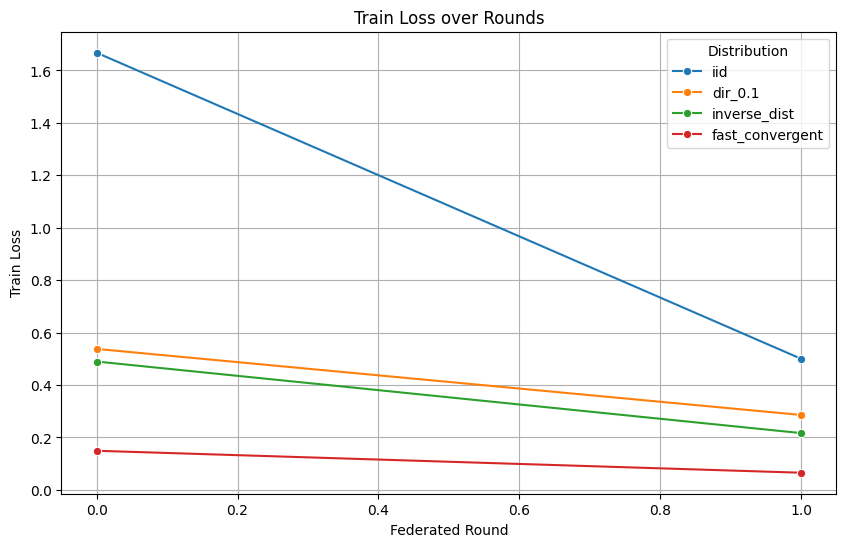

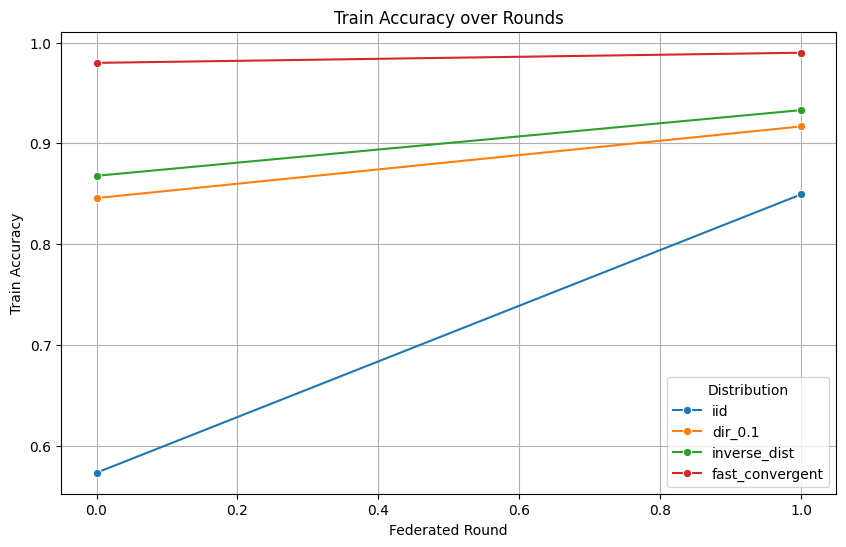

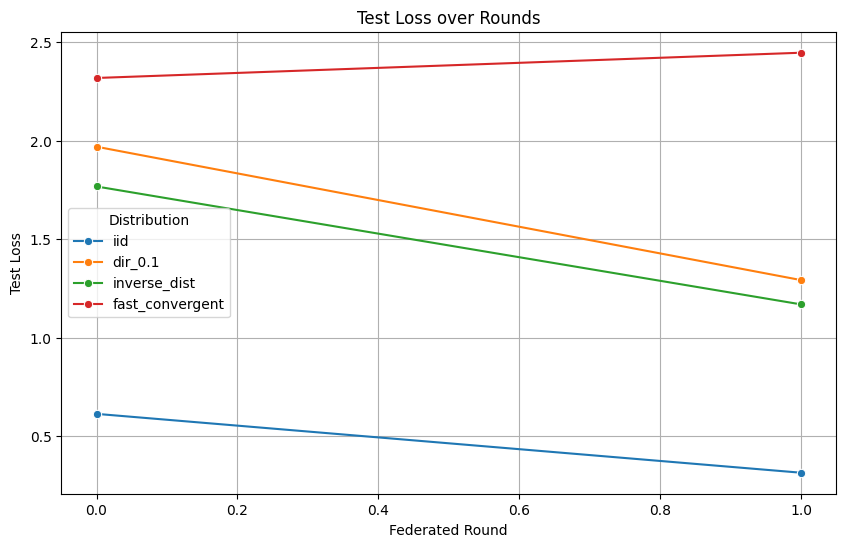

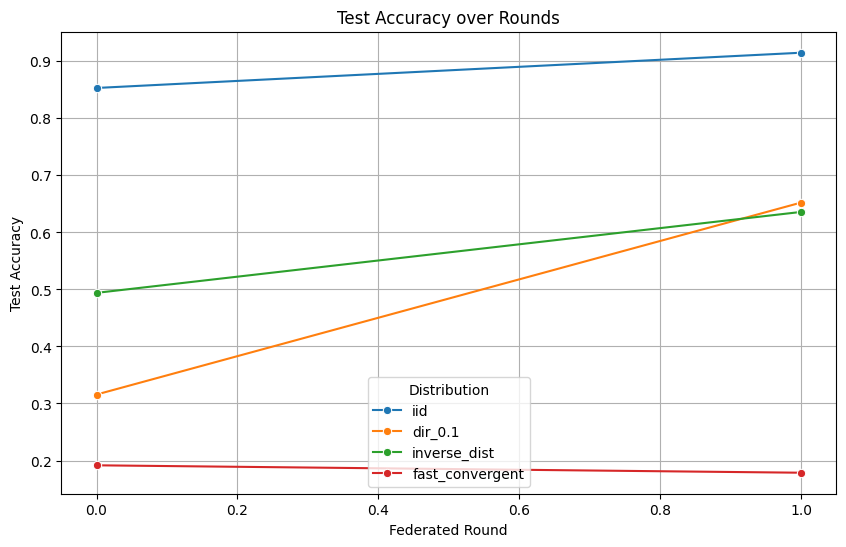

In [ ]:
import tensorflow as tf
import tensorflow_federated as tff
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import collections
import pprint

# --- BATCH SPEC ---
BATCH_SPEC = collections.OrderedDict(
    x=tf.TensorSpec(shape=[None, 28, 28, 1], dtype=tf.float32),
    y=tf.TensorSpec(shape=[None], dtype=tf.int32),
)

# --- MODEL DEFINITION ---
def model_fn():
    keras_model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, 5, padding='same', activation='relu', input_shape=(28,28,1)),
        tf.keras.layers.MaxPooling2D(2),
        tf.keras.layers.Conv2D(64, 5, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(10)
    ])
    return tff.learning.models.from_keras_model(
        keras_model,
        input_spec=BATCH_SPEC,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
    )

# --- FEDERATED ALGORITHMS ---
iterative_process = tff.learning.algorithms.build_unweighted_fed_avg(
    model_fn=model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.01)
)

evaluation = tff.learning.algorithms.build_fed_eval(model_fn)

# --- INITIALIZE MODEL STATE ---
initial_state = iterative_process.initialize()
initial_weights = initial_state.global_model_weights

# --- FEDERATED TEST DATA (Assumed preloaded) ---
# federated_test_data = [get_data_for_digits((x_test, y_test), [d]) for d in range(10)]

# --- DISTRIBUTIONS (Assumed you defined them like below) ---
# Example:
# distributions = {
#     'iid': fedtsa_distribution((x_train, y_train), 10, 10),
#     'dir_0.1': get_dirichlet((x_train, y_train), 0.1, 10),
#     'dir_1.0': get_dirichlet((x_train, y_train), 1.0, 10)
# }

# --- TRAINING AND EVALUATION LOOP ---
all_metrics = []

for name, fed_train_data in distributions.items():
    print(f"\n--- Training on distribution: {name} ---")

    # Reset to initial model weights
    state = iterative_process.initialize()
    state = state._replace(global_model_weights=initial_weights)

    for round_num in range(0, 2):
        state, train_metrics = iterative_process.next(state, fed_train_data)

        # Evaluate after each round
        eval_state = evaluation.initialize()
        eval_state = eval_state._replace(global_model_weights=state.global_model_weights)
        eval_output = evaluation.next(eval_state, federated_test_data)
        eval_metrics = eval_output.metrics

        # Extract metrics safely
        train_acc = train_metrics['client_work']['train'].get('sparse_categorical_accuracy', -1)
        train_loss = train_metrics['client_work']['train'].get('loss', -1)
        test_acc = eval_metrics['client_work']['eval']['current_round_metrics']['sparse_categorical_accuracy']
        test_loss = eval_metrics['client_work']['eval']['current_round_metrics']['loss']

        print(f"{name} | Round {round_num:02d} | Train acc: {train_acc:.4f} | Test acc: {test_acc:.4f}")

        all_metrics.append({
            'distribution': name,
            'round': round_num,
            'train_loss': train_loss,
            'train_accuracy': train_acc,
            'test_loss': test_loss,
            'test_accuracy': test_acc
        })

# --- SAVE TO EXCEL ---
df = pd.DataFrame(all_metrics)
df.to_excel("federated_training_metrics.xlsx", index=False)

# from google.colab import files
# files.download("federated_training_metrics.xlsx")

# --- PLOTTING ---
def plot_metric(df, metric):
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df, x='round', y=metric, hue='distribution', marker='o')
    plt.title(f"{metric.replace('_', ' ').title()} over Rounds")
    plt.grid(True)
    plt.xlabel("Federated Round")
    plt.ylabel(metric.replace("_", " ").title())
    plt.legend(title='Distribution')
    plt.show()

for metric in ['train_loss', 'train_accuracy', 'test_loss', 'test_accuracy']:
    plot_metric(df, metric)


In [ ]:
import pprint
pprint.pprint(eval_metrics)

OrderedDict([('distributor', ()),
             ('client_work',
              OrderedDict([('eval',
                            OrderedDict([('current_round_metrics',
                                          OrderedDict([('sparse_categorical_accuracy',
                                                        0.8117),
                                                       ('loss', 0.7545986),
                                                       ('num_examples', 10000),
                                                       ('num_batches', 105)])),
                                         ('total_rounds_metrics',
                                          OrderedDict([('sparse_categorical_accuracy',
                                                        0.8117),
                                                       ('loss', 0.7545986),
                                                       ('num_examples', 10000),
                                                       ('num_batches',
 

In [ ]:
from google.colab import files
files.download("federated_training_metrics.xlsx")

FileNotFoundError: Cannot find file: federated_training_metrics.xlsx